**Table of contents**<a id='toc0_'></a>    
- 1. [Load data             ](#toc1_)    
  - 1.1. [Load earthquake catalog             ](#toc1_1_)    
  - 1.2. [Load tremor catalog             ](#toc1_2_)    
- 2. [Project events along strike   ](#toc2_)    
- 3. [Trim catalogs  ](#toc3_)    
- 4. [Measure earthquake-tremor distance  ](#toc4_)    
- 5. [Count number of earthquakes "felt" by tremor        ](#toc5_)    
- 6. [Inspect results  ](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Imports
%matplotlib inline 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    workdir = '/Users/gaspard/Documents/work/'

# 1. <a id='toc1_'></a>Load data              [&#128285;](#toc0_)

## 1.1. <a id='toc1_1_'></a>Load earthquake catalog              [&#128285;](#toc0_)

In [2]:
# Directly load catalog from csv
eq = pd.read_csv(workdir + 'projects/data/Catalogs/JMA/jma_1951_2023.csv')
eq['date'] = pd.to_datetime(eq['date'])
eq.rename(columns={'longitude': 'lon', 'latitude': 'lat'}, inplace=True)

# Filter catalog
eq = eq[eq['evtype'] == 1]  # keep only earthquakes
eq = eq[eq['mag'] >= 1]  # keep only earthquakes with magnitude >= 1
eq = eq[eq['date'] >= '2000-01-01']  # keep only earthquakes after 2000 (shorter computation time)

lon_min = 130
lon_max = 140
lat_min = 31
lat_max = 37

indicator = (eq.lon > lon_min) & (eq.lon < lon_max) & (eq.lat > lat_min) & (eq.lat < lat_max)
eq = eq[indicator].copy()
print('{:d} events in the selected region'.format(len(eq)))

493553 events in the selected region


## 1.2. <a id='toc1_2_'></a>Load tremor catalog              [&#128285;](#toc0_)

In [3]:
# Load data
path = workdir + 'projects/data/Catalogs/world_tremor_database/nankai_wtb_0413_clust.csv'

COLS = ['date', 'time', 'lat', 'lon', 'depth', 'mag', 'dur', 'err', 'optional_date']
trm = pd.read_csv(
    path,
    names=COLS,
)

trm['date_str'] = trm.date.values + ' ' + trm.time.values
trm['date'] = pd.to_datetime(trm.date_str)
day0 = np.datetime64('2004-01-01')
trm['day'] = (trm.date - day0) / np.timedelta64(1, 'D')

trm.sort_values(by=["date"], inplace=True)
print('{:d} tremor detections, spanning {:d}--{:d}'.format(trm.shape[0], trm.date.min().year, trm.date.max().year))

55127 tremor detections, spanning 2004--2013


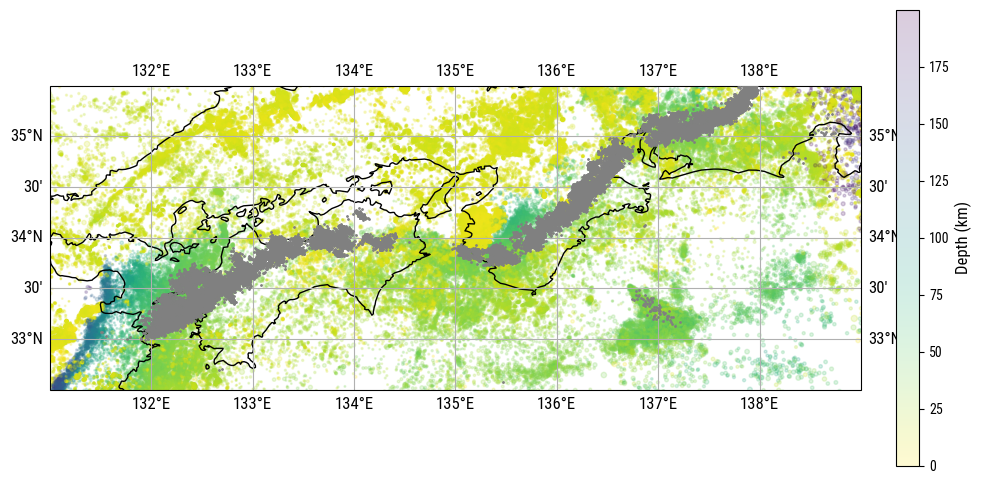

In [4]:
# Plot it
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([131, 139, 32.5, 35.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.scatter(trm.lon, trm.lat, s=1, c='.5', transform=ccrs.PlateCarree(), zorder=10)
sc = ax.scatter(eq.lon[eq.depth<200], eq.lat[eq.depth<200], s=eq.mag[eq.depth<200]**2, c=eq.depth[eq.depth<200], transform=ccrs.PlateCarree(), alpha=.2, cmap='viridis_r')
plt.colorbar(sc, label='Depth (km)', pad=0.04, fraction=0.046)

plt.tight_layout()
plt.show()

# 2. <a id='toc2_'></a>Project events along strike    [&#128285;](#toc0_)

In [5]:
# Define strike
# --> Get cartesian coordinates for everyone
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

trm_coords = crs.transform_points(ccrs.PlateCarree(), trm.lon.values, trm.lat.values)
eq_coords = crs.transform_points(ccrs.PlateCarree(), eq.lon.values, eq.lat.values)

trm.loc[:, 'x'] = trm_coords[:, 0]/1000  # x is easting (km)
trm.loc[:, 'y'] = trm_coords[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000

# Define along-strike: fit a polynomial to the tremor line, loaded from the main tremor catalog
import pickle
along_strike = pickle.load(open('data/nankai/processed/nankai_along_strike.pkl', 'rb'))
X = along_strike['x']
Y = along_strike['y']
S = along_strike['s']


# p_strike = np.polyfit(trm.x, trm.y, 10)

# # --> Define a strike line with evenly spaced points along it
# x0, y0 = -300, np.polyval(p_strike, -300)   # initial point
# ds = .01 # spacing along the curve in km

# X, Y = [], []  # initialize the location of the points along the line
# X.append(x0)
# Y.append(y0)
# x = x0
# while x < 400:
#     # Using the arc-length formula, we can find the dy to the next point,
#     # and then using the polynomial, we can find the corresponding x.
#     dx = ds / np.sqrt(1 + (np.polyval(np.polyder(p_strike), x))**2)
#     x += dx
#     y = np.polyval(p_strike, x)
#     X.append(x)
#     Y.append(y)

# S = np.cumsum(np.ones(len(X)) * ds) - ds  # along-strike distance for each (X, Y)

# --> Find nearest neighbor — but the distance matrix is huge, so make a tree of the strike points 
# to have a rough first guess before computing the nearest neighbor
from scipy.spatial import cKDTree

tree = cKDTree(np.column_stack((X, Y)))
trm_across_strike_dist, trm_nearest_idx = tree.query(np.column_stack((trm.x, trm.y)))

trm_along_strike_dist = S[trm_nearest_idx]

trm['xf'] = trm_along_strike_dist
trm['yf'] = trm_across_strike_dist

# # Show
# fig, axes = plt.subplots(2, 1, figsize=(10, 10))
# for ax in axes:
#     ax.set_aspect('equal')
#     ax.set_xlabel('x (km)')  
#     ax.set_ylabel('y (km)')
#     ax.plot(X, Y, 'r', zorder=10)

# # axes[0].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_along_strike_dist, ec='k', cmap='viridis', vmin=0, vmax=1500)
# axes[0].scatter(trm.x, trm.y, s=1, c=trm_along_strike_dist, cmap='viridis', vmin=0, vmax=1000)

# # axes[1].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_across_strike_dist, ec='k', cmap='viridis')
# axes[1].scatter(trm.x, trm.y, s=1, c=trm_across_strike_dist, cmap='viridis', vmax=50)

# plt.tight_layout()
# plt.show()


In [6]:
# Project earthquakes along-strike: nearest point from each event to the strike line (~1min for 1.7M events)
eq_across_strike_dist, eq_nearest_idx = tree.query(np.column_stack((eq.x, eq.y)))
eq_along_strike_dist = S[eq_nearest_idx]

eq['xf'] = eq_along_strike_dist  # xf or xfault: along-strike distance in km
eq['yf'] = eq_across_strike_dist  # yf or yfault: across-strike distance in km

# # Show
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.set_aspect('equal')
# ax.set_xlabel('x (km)')
# ax.set_ylabel('y (km)')

# ax.plot(X, Y, 'r', zorder=10)
# ax.scatter(eq.x, eq.y, c=eq.xf, s=1, zorder=1)
# ax.scatter(trm.x, trm.y, c='k', s=1, zorder=9)

# plt.tight_layout()
# plt.show()

# 3. <a id='toc3_'></a>Trim catalogs   [&#128285;](#toc0_)

In [7]:
# Trim tremor to exclude shallower regions
xf_max = 700
yf_max = 50

indicator = (trm.xf < xf_max) & (trm.yf < yf_max)

# fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_aspect('equal')
# ax.set_xlabel('x (km)')
# ax.set_ylabel('y (km)')
# ax.plot(X, Y, 'r', zorder=10)
# ax.plot(trm.x, trm.y, 'k.', ms=1)
# ax.plot(trm.x[indicator], trm.y[indicator], 'b.', ms=1)

# plt.tight_layout()
# plt.show()

trm = trm[indicator]

In [8]:
# Trim earthquakes and tremor to same time period
print('Tremor', trm.date.min(), trm.date.max())
print('Earthquakes', eq.date.min(), eq.date.max())

interval = [np.datetime64('2004-04-01'), np.datetime64('2013-04-01')]
eq = eq[(eq.date.values > interval[0]) & (eq.date.values < interval[1])]
trm = trm[(trm.date.values > interval[0]) & (trm.date.values < interval[1])]

print('\nChosen interval', interval)

Tremor 2004-04-01 06:06:21 2013-03-31 20:47:26
Earthquakes 2000-01-01 03:50:13.020000 2023-03-31 23:39:27.180000

Chosen interval [np.datetime64('2004-04-01'), np.datetime64('2013-04-01')]


# 4. <a id='toc4_'></a>Measure earthquake-tremor distance   [&#128285;](#toc0_)

In [9]:
# Measure distance between earthquakes and the nearest tremor event
tree = cKDTree(np.column_stack((trm.x.values, trm.y.values, trm.depth.values)))

dist2trm, idx = tree.query(np.column_stack((eq.x, eq.y, eq.depth)))
eq['dist2trm'] = dist2trm

In [10]:
# Save processed earthquakes (trimmed, distance to tremor computed)
path = 'data/nankai/processed/nank_eq_0404_0413.csv'
print('Saving to ', path)
eq.to_csv(path)

Saving to  data/nankai/processed/nank_eq_0404_0413.csv


# 5. <a id='toc5_'></a>Count number of earthquakes "felt" by tremor         [&#128285;](#toc0_)

In [11]:
# Which distance and magnitude bins
min_mags = [2.4, 2.2, 2., 1.8, 1.5, 1.]
distances = [10, 20, 30, 50, 100]

In [12]:
# Run through minimum magnitudes and distance, and compute number of earthquakes within distance of tremor (~10 min for the whole run)

for min_mag in min_mags:
    # --> Select earthquakes
    selected_eq = eq[
        (eq.mag >= min_mag) \
        & (eq.dist2trm <= np.max(distances))
    ]
    print('Mmin =', min_mag, 'Neq =', len(selected_eq))

    # --> Make trees
    eq_tree = cKDTree(selected_eq[['x', 'y', 'depth']].values)
    trm_tree = cKDTree(trm[['x', 'y', 'depth']].values)
    
    for dist in distances:
        print('d <', dist)
        # Query tremor tree to find which earthquakes are closer than `dist`
        eq_neighbors_idxs = trm_tree.query_ball_tree(eq_tree, dist)  # a tuple of eq indices for each tremor event

        # Count number of neighbors for each tremor event
        n_eq_neighbors = np.array([len(e) for e in eq_neighbors_idxs])

        # Convert to number of eq neighbors per year analyzed
        n_eq_neighbors = n_eq_neighbors / ((interval[1] - interval[0]).astype('timedelta64[D]').astype(int) / 365)

        # Store information in tremor dataset
        new_key = "m{:.1f}in{:d}km".format(min_mag, dist)
        trm[new_key] = n_eq_neighbors

Mmin = 2.4 Neq = 5295
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 2.2 Neq = 7817
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 2.0 Neq = 11484
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.8 Neq = 16831
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.5 Neq = 29979
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.0 Neq = 79133
d < 10
d < 20
d < 30
d < 50
d < 100


In [13]:
# Save processed tremor dataset
path = 'data/nankai/processed/nank_trm_0404_0413.csv'
print('Saving at', path)
trm.to_csv(path)

Saving at data/nankai/processed/nank_trm_0404_0413.csv


# 6. <a id='toc6_'></a>Inspect results   [&#128285;](#toc0_)

In [14]:
# Load processed results
trm = pd.read_csv('data/nankai/processed/nank_trm_0404_0413.csv')
eq = pd.read_csv('data/nankai/processed/nank_eq_0404_0413.csv')

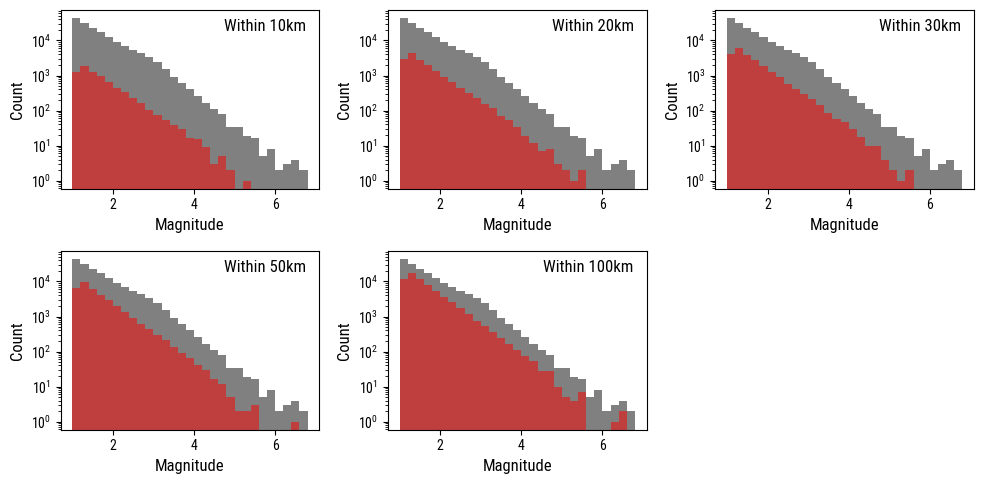

In [15]:
# Magnitude of completeness for each distance

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for ii in range(6):
    if ii == 5: axes[ii//3, ii%3].remove() ; continue
    ax = axes[ii//3, ii%3]
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    ax.text(.95, .95, 'Within {:d}km'.format(distances[ii]), va='top', ha='right', transform=ax.transAxes)

    ax.hist(eq.mag.values, bins=np.arange(1, 7, .2), fc='gray', ec='none')
    ax.hist(eq.mag[(eq.mag > 1) & (eq.dist2trm < distances[ii])].values, bins=np.arange(1, 7, .2), fc=to_rgba('r', .5), ec='none')

plt.tight_layout()
plt.show()

In [16]:
# Which distance/minimum magnitude for maps
min_mag = 2.2

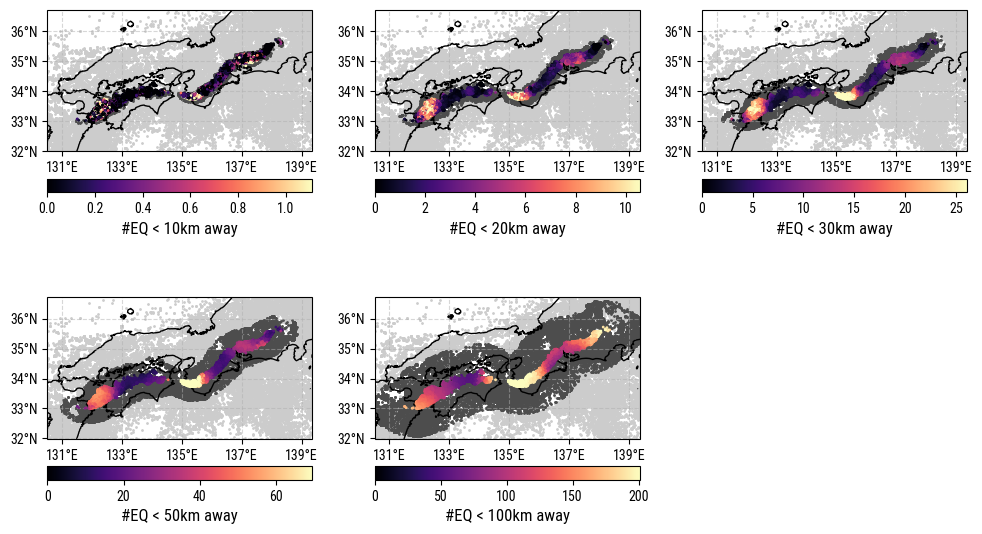

In [17]:
# Maps
lon_min = trm.lon.min() - 1
lon_max = trm.lon.max() + 1
lat_min = trm.lat.min() - 1
lat_max = trm.lat.max() + 1
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 6))
axes = [plt.subplot(2, 3, ii+1, projection=crs) for ii in range(5)]

for ii, ax in zip(range(len(distances)), np.array(axes).flatten()):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    ax.coastlines(lw=1)

    # Plot tremor
    sc = ax.scatter(trm.lon, trm.lat, c=trm['m{:.1f}in{:d}km'.format(min_mag, distances[ii])], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(trm['m{:.1f}in{:d}km'.format(min_mag, distances[ii])], 95), zorder=2, label='Tremor')
    ax.scatter(eq[eq.dist2trm < distances[ii]].lon, eq[eq.dist2trm < distances[ii]].lat, c='.3', s=1, transform=crs, zorder=1, label='Earthquakes in range'.format(distances[ii]))
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=crs, zorder=0, label='All earthquakes')

    # Colorbar
    x_min_ax = 0.5; y_min_ax = -0.2
    w_ax = 0.45; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    cbar = plt.colorbar(sc, orientation='horizontal', label="#EQ < {:d}km away".format(distances[ii]), fraction=0.3, pad=0.1)

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=crs)
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()